# Lab Sheet 6 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-7.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [n.ma@sheffield.ac.uk](mailto:n.ma@sheffield.ac.uk).

<div class="alert alert-block alert-success" id='ILOs'>
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notenook you should
    
<ul>
<li>further familiarise with correlation and the autocorrelation sequence.
</li>
<li>be able to use the autocorrelation sequence to estimate the fundamental freuency / pitch frequency of a signal
</li>
<li>be able to generate a glottal impulse
</li>
<li>understand basic use of the <code>Python</code> libraries 
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> commands 
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.correlate.html"><code>correlate()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.floor.html"><code>floor()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.ceil.html"><code>ceil()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.round.html"><code>round()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.arange.html"><code>arange()</code></a>,
        etc.
    </li>
    <li><a href="https://matplotlib.org/"><code>Matplotlib</code></a> for graphical output (like 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html"><code>gca()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.twiny.html"><code>twiny()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_xticks.html"><code>get_xticks()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html"><code>set_xticks()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_xbound.html"><code>get_xbound()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xbound.html"><code>set_xbound()</code></a>,
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html"><code>set_xticklabels()</code></a>,
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlabel.html"><code>set_xlabel()</code></a>,
        etc.)
    </li>
    </ul>
</li>
</ul>
</div>

In [2]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib notebook
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd

We can create a periodically repeated noise signal of length $𝐿=8000$ samples by concatenating $𝐿/𝑃$ repetitions of a random signal of length $𝑃=100$ samples, using the following code. We will use this signal for autocorrelation analysis.

<IPython.core.display.Javascript object>


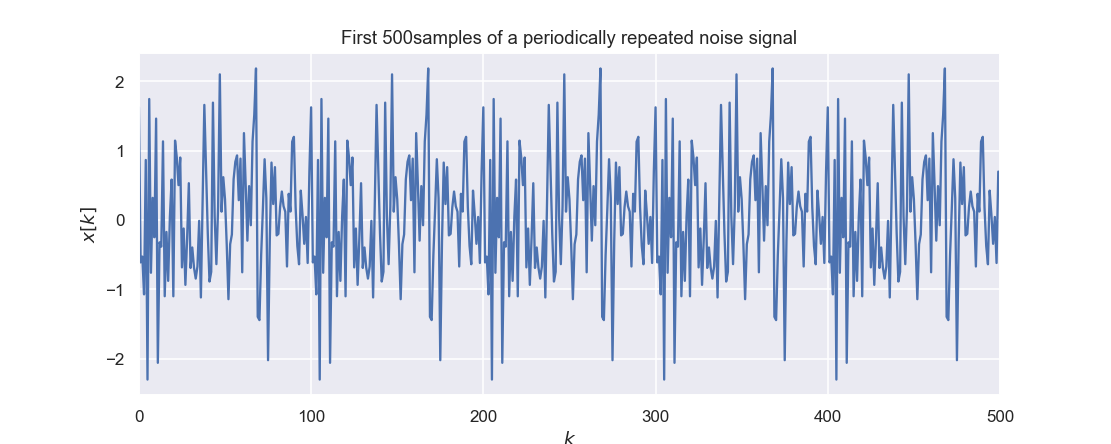

In [3]:
L = 8000 # total length of signal
P = 100  # period

K = 250  # analysis length

# generate periodic random signal
np.random.seed(1) # this ensures that always the same "random" signal is generated
x0 = np.random.normal(size=P)
x  = np.tile(x0, L//P)

plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.title('First '+str(2*K)+'samples of a periodically repeated noise signal')
plt.grid(True)

# listen to the sound file
ipd.Audio(x, rate=8000)

## Autocorrelation Sequence, a.k.a. Autocorrelation Function

In the [previous notebook (Lab-Sheet 3)](./../Lab-Sheet-Solutions/Lab-Sheet-3-Solution.ipynb) we calculated the [Correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and the correlation coefficient $\hat{r}_{xx}$ as a scalar quantity indicating how correlated two signals (of the same length) are.

Today, we are not only interested in the scalar correlation between two signals $x[k]$ and $y[k]$ but also in the (auto-)correlation between $x[k]$ and $x[k-\kappa]$, the time-shifted version of $x[k]$. This information can be analysed by the [auto-correlation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF) which characterizes the temporal dependencies within one random signal $x[k]$. 

We define the *autocorrelation function estimate* at a time shift $\kappa$ of the signal $x[k]$ of length $L$ as

\begin{equation}
\hat{r}_{xx}[\kappa] = \frac{1}{L} \sum_{k=1}^{L}x[k]x[k+\kappa]  \tag{1}
\label{eq:AutocorrelationEstFullSum}
\end{equation}

for all values of $\kappa$ from $0$ to $L-1$, i.e., for each $\kappa$ we correlate the non-shifted signal with a signal shifted by $\kappa$ samples.

We observe that the sum in (\ref{eq:AutocorrelationEstFullSum}) is not well defined as  $x[k+\kappa]$ is unknown for $k+\kappa>L$. We have to assume that the signals are zero-padded by as many zeros before and after the actual signal as needed to calculate the sum. We call this *zero-padding*. We will be using the Python's `np.correlate()` function to calculate the correlation. The option `mode='full'` ensures proper automatic zero-padding.


<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 1: Calculate the autocorrelation function for the periodically repeated random signal**
    
<ul>
<li> 
    Calculate the ACF using the <code>np.correlate()</code> function and the parameter <code>mode='full'</code>. Note, that the normalisation by $1/L$ has to be added manually. 
</li>
<li> 
    The resulting ACF vector is of length $2L-1$ ranging from $-(L-1)$ to $(L-1)$. The interesting are is in the middle of the vector, i.e. around $\kappa =0$. Thus, plot the ACF for the samples $-(K-1) \leq \kappa \leq (K-1)$ with $K=250$.
</li>  
</ul>
</div>


In [ ]:
# your code here
# ....

## Autocorrelation of a Voiced Speech Segment

<a id='task_2'></a>
<div class="alert alert-block alert-info">
    
**Task 2: Calculate the autocorrelation function for a speech signal**
    
<ul>
<li> 
    Download the file <code>https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/voiced_unvoiced_e.wav</code> and load it to a variable <code>s</code>. 
</li>
<li> 
    Plot the ACF for the samples $-(K-1) \leq \kappa \leq (K-1)$ with $K=500$.
</li>  
</ul>
</div>

In [ ]:
# your code here
# ....

## Fundamental Frequency Estimation

With the knowledge from the ACF estimate $\hat{r}_{xx}[\kappa]$, we will now extract the fundamental frequency, a.k.a. pitch frequency, of a speech signal.

<br>
To determine the periodicity of the signal we are interested in the distance of the ACF maxima. Since we know that we always have a maximum at $\kappa=0$ we are interested in identifying the second maximum.

To be more robust in case of mixed (voiced/unvoiced) excitation  signals, we only look in the time shift range which corresponds to sensible frequencies (limited by $f_{min}$ and $f_{max}$ as visualised in orange in the figure below). Typical pitch frequencies are in an range between $f_{min}=50$ Hz and $f_{max}=500$ Hz. With the knowledge that discrete time variables $\kappa$ are related to discrete frequency variables by the sampling frequency $f_s$ we can calculate the *search area* (orange shaded below) between $\kappa_{\mathrm{max}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{max}}}\right)$ and $\kappa_{\mathrm{min}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{min}}}\right)$.

<img src="autocorrelation_frequencies.svg" align="center"/>
<center><span style="font-size:smaller">
    <b>Fig. 1:</b> Autocorrelation sequence with <i>search area</i> in ornage and identified main peak $\kappa_0, \kappa_0>0$ in green.
</span></center>



We now want to determine the fundamental frequency of the speech signal $s[k]$ from the ACF we just calculated.

<br>
<a id='task_4'></a>
<div class="alert alert-block alert-info">
    
**Task 3: Calculation of Pitch Frequency**
    
<ul>
<li> 
    Search for the highest peak in the ACF in the search area defined by $f_{min}=50$ Hz and $f_{max}=500$ Hz. The function <code>np.argmax()</code> might be helpful for this. Note that the absolute numbers in the figure above are only valid if the sampling frequency $f_s$ matches.
</li>
<li> 
    Calculate the pitch frequency $f_p=f_s \cdot \kappa_{\mathrm{peak}}$, i.e. $f_p=f_s \cdot \kappa_{0}$. 
</li>  
</ul>
</div>

In [ ]:
# your code here
# ....

## Generation of Glottal Exitation Signal

A single glottal impulse is shown in [Fig. 2](#SpeechGenerationGlottalImpulse) exemplarily for a sampling frequency of $f_s=8 \,\mathrm{kHz}$ and a pitch frequency of $f_p = 150 \,\mathrm{Hz}$, i.e. the signal part shown in [Fig. 2](#SpeechGenerationGlottalImpulse) would be repeated $150$ times per second.

<img id='SpeechGenerationGlottalImpulse' src="SpeechGenerationGlottalImpulse.svg" align="center" width="700px">
<center><span style="font-size:smaller">
    <b>Fig. 2:</b> Single glottal impulse.
</span></center>

We call the length of the impulse in seconds $T_0=\frac{1}{f_p}$, and the length in samples can be determined by

\begin{equation}
L_g = \left\lfloor \frac{f_s}{f_p} \right\rfloor 
\label{eq:glottalImpulseLength}\tag{1}
\end{equation}

with the operator $\lfloor \cdot \rfloor$ in (\ref{eq:glottalImpulseLength}) being the flooring operator, implemented in `Python` as `np.floor()`. For the chosen example of $f_p = 150 \,\mathrm{Hz}$ and $f_s=8 \,\mathrm{kHz}$, the impulse length in seconds is $T_0=\frac{1}{f_p}=6.\bar{6} \,\mathrm{ms}$ and the length in samples is $L_g = \left\lfloor \frac{8,000 \,\mathrm{Hz}}{150 \,\mathrm{Hz}} \right\rfloor  = 53$, as it also can be seen in [Fig. 2](#SpeechGenerationGlottalImpulse). 

This pulse can be decomposed in three parts [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf),
* (i) an *attack* part, i.e. the time of the raising branch, for time $t$ ranging from $0$ seconds to the time of the peak (maximum) $t_{\mathrm{peak}}$, which is a parameter we can choose and which was chosen in the example in [Fig. 2](#SpeechGenerationGlottalImpulse) to be approx $35 \%$ of the overall length, i.e. $t_{\mathrm{peak}}= 35 \% \cdot T_0$, or in samples $L_{\mathrm{attack}}=\left\lfloor 35 \% \cdot L_g \right\rceil$ with the operator $\left\lfloor \cdot \right\rceil$, being the rounding operator, implemented in `Python` as `np.round()`,
* (ii) a *decay* or *release* part, i.e. the descending branch, for time $t$ ranging from $t_{\mathrm{peak}}$ to $t_c$, and 
* (iii) a *sustain* part, i.e. a period without change, here of silence (zeros),

\begin{equation}
g(t) = 
\left\{
\begin{array}{lll}
g_{\mathrm{attack}}(t)  & \text{for } 0<t<t_{\mathrm{peak}},      & \text{the attack or rising branch,} \\
g_{\mathrm{release}}(t) & \text{for } t_{\mathrm{peak}}< t < t_c, & \text{the decay or or release or descending branch,} \\
g_{\mathrm{sustain}}(t) & \text{for } t_c < t < T_0,              & \text{the sustain or zero part,}
\end{array}
\right.
\label{eq:glottalImpulseSchematic}\tag{2}
\end{equation}

Following [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf), the time $t_c$ can be calculated by

\begin{equation}
t_c=t_{\mathrm{peak}}+\frac{\mathrm{arcos}\left(\frac{K-1}{K}\right)}{\omega_g},
\label{eq:DecayReleaseTime} \tag{3}
\end{equation}

with $K$ being another paprameter influencing the steepness of the decaying part. For $K=0.5$, the impulse is symetric and a typical value might be $K=2$. Defining the three parts of the glottal impluse mathematically leads to [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf)

\begin{equation}
g(t) = 
\left\{
\begin{array}{ll}
\frac{1}{2}(1-\mathrm{cos}(\omega_g t)) &  \text{for } 0<t<t_{\mathrm{peak}}, \\
K \cdot \mathrm{cos}(\omega_g(t-t_{\mathrm{peak}}))-K+ 1 & \text{for } t_{\mathrm{peak}}< t < t_c,  \\
0 & \text{for } t_c < t < T_0,
\end{array}
\right.
\label{eq:glottalImpulse}\tag{4}
\end{equation}

The angular frequency needed in (\ref{eq:DecayReleaseTime}) and (\ref{eq:glottalImpulse}) can be defined as $\omega_g = \pi/t_{\mathrm{peak}}$.


<br>
<a id='task_5'></a>
<div class="alert alert-block alert-info">
    
**Task 4: Generating Raining Branch of Glottal Impulse**

Let's create the glottal pulse in (\ref{eq:glottalImpulse}) step by step for a sampling frequency of $f_s=8 \,\mathrm{kHz}$, a pitch frequency of $f_p = 150 \,\mathrm{Hz}$ and for parameters $K=2$ (you might play around with this) and $t_{\mathrm{peak}}= 35 \% \cdot T_0$, revising some exercises implemented before.  For this, let's focus on the first part, the raising branch first which is nothing else than a raised cosine. 

\begin{equation}
g_{\mathrm{attack}}(t) =
\frac{1}{2}(1-\mathrm{cos}(\omega_g t)) \quad \text{if } 0 < t < t_{\mathrm{peak}}
\end{equation}
    
Note that the time $t_{\mathrm{peak}}$ can be calculated from the length $T_0$ and that you want to implement the discrete version $g_{\mathrm{attack}}[k]$ of the pulse $g_{\mathrm{attack}}(t)$, therefore you would need $L_g$ instead of $T_0$.

To achieve calculating $g_{\mathrm{attack}}(t)$ step-by-step we
<ul>
<li> 
    first creare a well know cosine signal $x_1(t_1) = \cos(\omega_g t_1)$ for a whole period, i.e. for times $0 \leq t_1 \leq L_g/f_s$. 
</li>
<li> 
    As a second step we create a *raised cosine*, i.e. $x_2(t_1) = 0.5 \dot (1-\cos(\omega_g t_1))$. 
</li>  
<li> 
    With this we can now simply truncate the time vector to times $0 \leq t \leq t_{\mathrm{peak}}$, reaslising that $t_{\mathrm{peak}} = L_{\mathrm{attack}} / f_s$.
</li>
</ul>
Aftre this exercise, you should be able to cretae the release part $g_{\mathrm{release}}$ directly from (\ref{eq:glottalImpulseSchematic}) and for $g_{\mathrm{sustain}}(t)$ you only need to concatenate zeros.
</div>

In [1]:
# your code here
# ....

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/),
[Ning Ma](https://sheffield.ac.uk/cs/people/academic/ning-ma)